# Customer Segmentation of Online Retail Customers

**Summary:**

* [1. Introduction](#1)
* [2. Required Packages and Data](#2)
* [3. Data Cleaning](#3)
    * [3.1. Handling Missing Values](#3-1)
    * [3.2. Treating Canceled Invoices](#3-2)
* [4. Feature Engineering and Preprocessing](#4)
    * [4.1. Feature Extraction](#4-1)
    * [4.2. RFM Analysis](#4-2)
    * [4.3. Removing Outliers](#4-3)
 * [5. Exploratory Data Analysis](#5)
    * [5.1. Revenue by Country](#5-1)
    * [5.2. Revenue by Month of the Year](#5-2)
    * [5.3. Revenue by Day of the Week](#5-3)
    * [5.4. Top 10 Customers by Revenue](#5-4)
    * [5.5. Customers RFM](#5-5)
* [6. Customer Segmentation (Clustering)](#6)
    * [6.1. Preprocessing](#6-1)
    * [6.2. Finding Number of Clusters](#6-2)
    * [6.3. Final Model](#6-3)

## <span id="1"></span>1. Introduction

In today's highly competitive business environment, companies are constantly looking for ways to gain an edge over their rivals. One of the most effective strategies that companies can use to increase their competitiveness is customer segmentation.

Customer segmentation is the process of dividing a company's customer base into smaller groups based on specific characteristics. By doing so, companies can tailor their marketing messages and product offerings to the unique needs and preferences of each segment. This can result in increased customer satisfaction, higher sales, and improved customer retention rates.

In this project we will perform customer segmentation and analysis using the [Dataset](https://www.kaggle.com/datasets/yasserh/customer-segmentation-dataset) from Kaggle.

**About the dataset:**
The dataset used in this project contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail. Many customers are wholesalers.

**Objective:**
Build and compare clustering models to segment the customers of the company from data built from the cited dataset.

**Steps:**
* Data Load and Preprocess
* Feature Engineering
* Exploratory Data Analysis (EDA)
* Build Clustering Models
* Evaluate Clustering Performance

## <span id="2"></span>2. Required Packages and Data

In [1]:
import math
import random
import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from datetime import timedelta
%matplotlib inline

sns.set_style("darkgrid")

from sklearn.manifold import TSNE
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    StandardScaler,
    MinMaxScaler,
    OrdinalEncoder,
    PowerTransformer,
    FunctionTransformer
)
from sklearn.compose import ColumnTransformer
from sklearn.cluster import DBSCAN, OPTICS, KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.neighbors import NearestNeighbors

from scipy.stats import norm

import warnings
warnings.filterwarnings("ignore")

seed = 42
random.seed(seed)
np.random.seed(seed)

df = pd.read_excel("../input/customer-segmentation-dataset/Online Retail.xlsx")
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [3]:
df.shape

(541909, 8)

## <span id="3"></span>3. Data Cleaning

### <span id="3-1"></span>3.1. Handling Missing Values

In [4]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

There are only two columns containing missing values: _Description_ and _CustomerID_. Considering the uniqueness nature of _CustomerID_, it does not make sense to fill the missing values with another value, so we will just drop them. The remaining missing values in the _Description_ column will be replaced with an empty string, so we can keep the rest of the information of those rows.

It is important to observe that after the removal of the missing values, a lot of data still remains in the dataset, so probably we won't have information loss problem.

In [5]:
df.drop(df[df["CustomerID"].isnull()].index, axis=0, inplace=True)
df["Description"] = df["Description"].fillna("")
df.isnull().sum().sum()

0

In [6]:
df.shape

(406829, 8)

### <span id="3-2"></span>3.2. Treating Canceled Invoices

Giving a deeper look into the values of _Quantity_, we can see some negative values. For the purpose of our analysis, it doesn't make sense to keep canceled invoices data in the dataset, so we will remove them along with their positive counterparts.

In [7]:
size_before = len(df)
neg_quantity = df[df["Quantity"] < 0][["CustomerID", "StockCode", "Quantity"]].sort_values("Quantity")
print(f"Negative Quantity: {len(neg_quantity)}")

filtered = df[df["CustomerID"].isin(neg_quantity["CustomerID"])]
filtered = filtered[filtered["StockCode"].isin(neg_quantity["StockCode"])]

pos_counters = []
for idx, series in neg_quantity.iterrows():
    customer = series["CustomerID"]
    code = series["StockCode"]
    quantity = -1 * series["Quantity"]
    counterpart = filtered[(filtered["CustomerID"] == customer) & (filtered["StockCode"] == code) & (filtered["Quantity"] == quantity)]
    pos_counters.extend(counterpart.index.to_list())

to_drop = neg_quantity.index.to_list() + pos_counters
df.drop(to_drop, axis=0, inplace=True)
print(f"Removed {size_before - len(df)} rows from the dataset")

Negative Quantity: 8905
Removed 14468 rows from the dataset


In [8]:
(df["Quantity"] <= 0).sum()

0

The dataset contains some rows where the value of UnitPrice is 0, so we will remove them.

In [9]:
df.drop(df[df["UnitPrice"] == 0].index, axis=0, inplace=True)

## <span id="4"></span>4. Feature Engineering and Preprocessing

In this section we will create and extract new features that will help us to understand better the data and get some insights about it. Also, we will remove some **outliers** that can disturb our analysis and decrease our clustering models performance.

### <span id="4-1"></span>4.1. Feature Extraction

In [10]:
# extracting time related features from InvoiceDate

df["InvoiceDateDay"] = df["InvoiceDate"].dt.date
df["InvoiceDateTime"] = df["InvoiceDate"].dt.time
df["InvoiceYear"] = df["InvoiceDate"].dt.year
df["InvoiceMonth"] = df["InvoiceDate"].dt.month
df["InvoiceMonthName"] = df["InvoiceDate"].dt.month_name()
df["InvoiceDay"] = df["InvoiceDate"].dt.day
df["InvoiceDayName"] = df["InvoiceDate"].dt.day_name()
df["InvoiceDayOfWeek"] = df["InvoiceDate"].dt.day_of_week
df["InvoiceWeekOfYear"] = df["InvoiceDate"].dt.weekofyear
df["InvoiceHour"] = df["InvoiceDate"].dt.hour

df["TotalValue"] = df["Quantity"] * df["UnitPrice"]

### <span id="4-2"></span>4.2. RFM Analysis

In the customer segmentation part of this project we will use RFM analysis to group the customers into meaningfull groups with similar purchasing behavior. RFM stands for Recency, Frequency and Monetary Value, the three key metrics used to segment customers.

In order to perform this analysis, we need to build a new DataFrame with a single row per customer containing the metrics cited above.

In [11]:
ref_date = df["InvoiceDateDay"].max() + timedelta(days=1)

df_customers = df.groupby("CustomerID").agg({
    "InvoiceDateDay": lambda x : (ref_date - x.max()).days,
    "InvoiceNo": "count",
    "TotalValue": "sum"
}).rename(columns={
    "InvoiceDateDay": "Recency",
    "InvoiceNo": "Frequency",
    "TotalValue": "MonetaryValue"
})

In [12]:
df_customers.head(10)

,Recency,Frequency,MonetaryValue
CustomerID,,,
12347.0,3,182,4310.00
12348.0,76,31,1797.24
12349.0,19,73,1757.55
12350.0,311,17,334.40
12352.0,37,67,1405.28
12353.0,205,4,89.00
12354.0,233,58,1079.40
12355.0,215,13,459.40
12356.0,23,59,2811.43


In [13]:
df_customers.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 4324 entries, 12347.0 to 18287.0
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Recency        4324 non-null   int64  
 1   Frequency      4324 non-null   int64  
 2   MonetaryValue  4324 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 135.1 KB


### <span id="4-3"></span>4.3. Removing Outliers

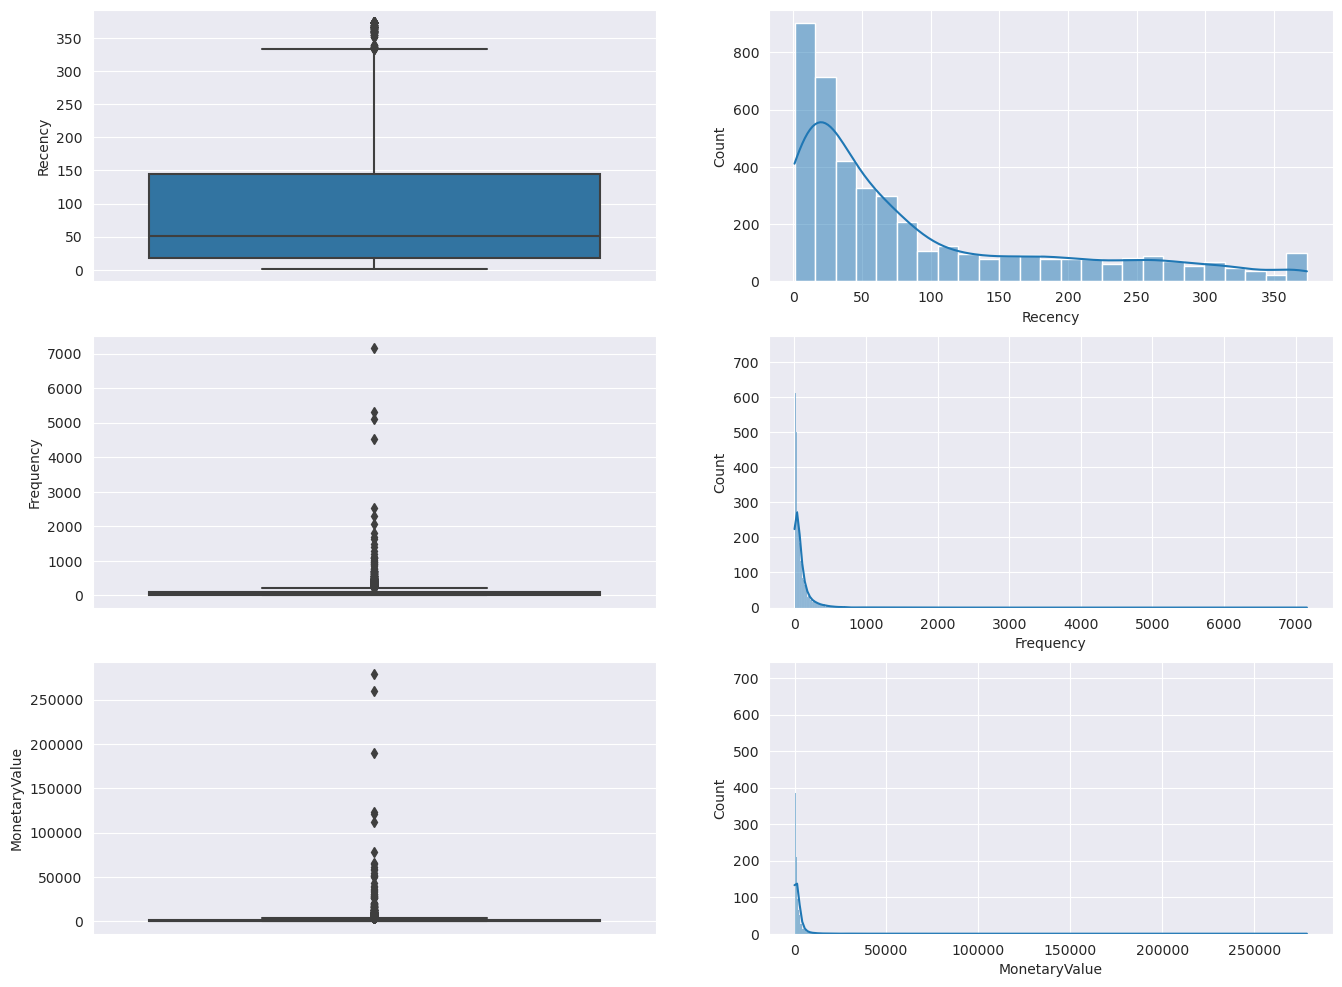

In [14]:
n_cols = len(df_customers.columns)
fig, axes = plt.subplots(n_cols, 2, figsize=(16, n_cols * 4))

for i, col in enumerate(df_customers.columns):
    sns.boxplot(data=df_customers, y=col, ax=axes[i][0])
    sns.histplot(data=df_customers, x=col, kde=True, ax=axes[i][1])

fig.show()

As we can see, because of the presence of **outliers** in our dataset, the data analysis becomes very difficult. Also, **outliers** can decrease our clustering models performance, adding some noisy behavior to our data, _biasing_ the estimated clusters. In order to prevent these problems, we will remove some of them through the IQR technique.

In [15]:
def remove_outliers(df, col, threshold=1.5):
    Q1 = np.quantile(df[col], .25)
    Q3 = np.quantile(df[col], .75)
    IQR = Q3 - Q1
    df.drop(df[(df[col] < (Q1 - threshold * IQR)) | (df[col] > (Q3 + threshold * IQR))].index, axis=0, inplace=True)
    
    return df

for col in df_customers.columns:
    size_before = len(df_customers)
    df_customers = remove_outliers(df_customers, col)
    print(f"Removed {size_before - len(df_customers)} outliers from {col}")

Removed 140 outliers from Recency
Removed 363 outliers from Frequency
Removed 316 outliers from MonetaryValue


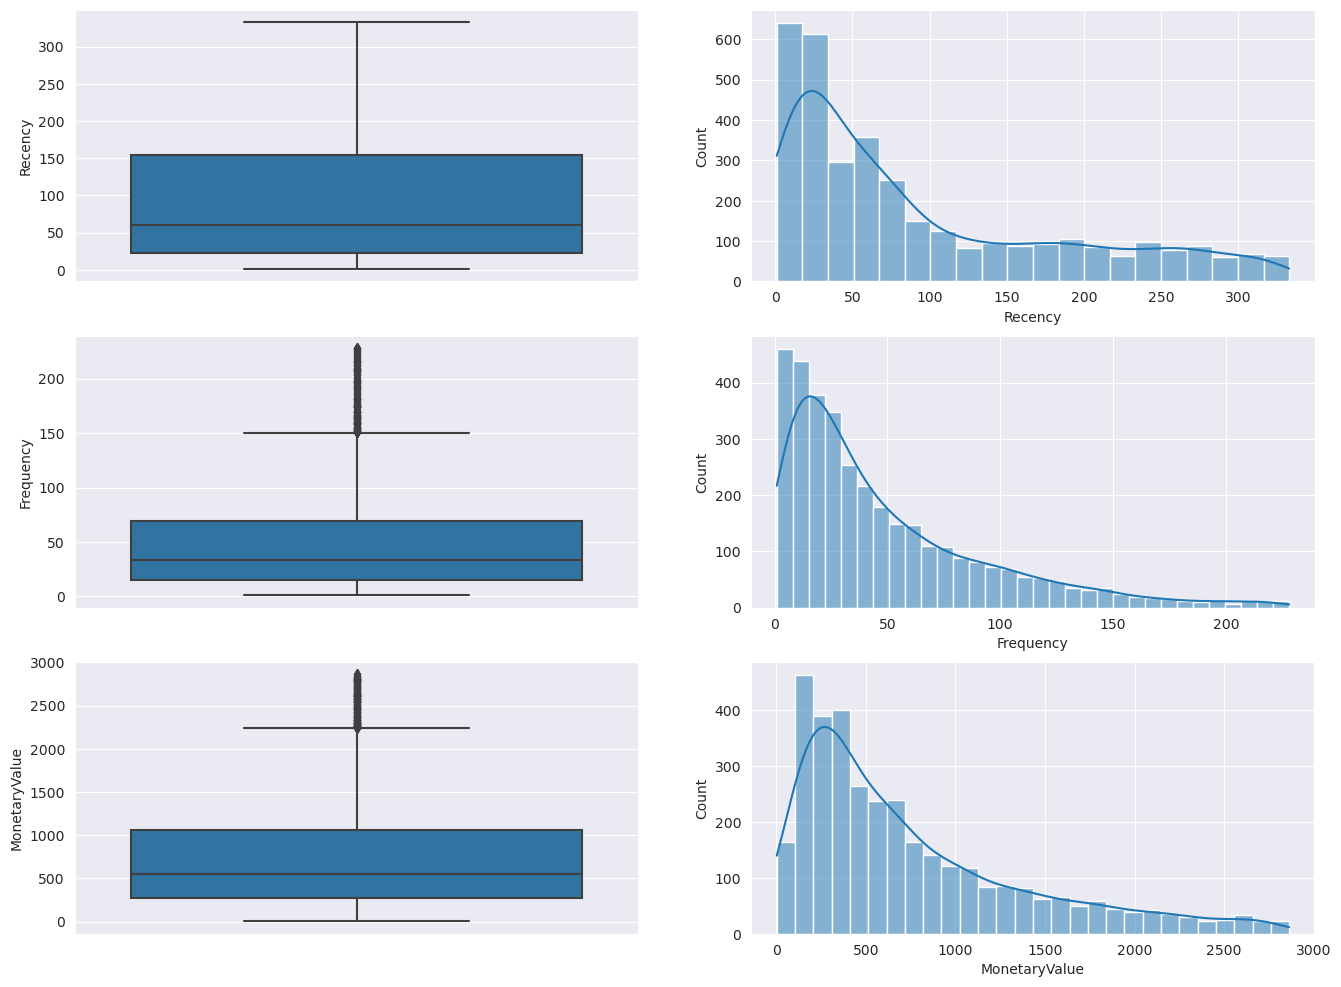

In [16]:
n_cols = len(df_customers.columns)
fig, axes = plt.subplots(n_cols, 2, figsize=(16, n_cols * 4))

for i, col in enumerate(df_customers.columns):
    sns.boxplot(data=df_customers, y=col, ax=axes[i][0])
    sns.histplot(data=df_customers, x=col, kde=True, ax=axes[i][1])

fig.show()

Our visualization and understanding about the data got much better now. So we can go further to the exploratory data analysis phase.

## <span id="5"></span>5. Exploratory Data Analysis

### <span id="5-1"></span>5.1. Revenue by Country

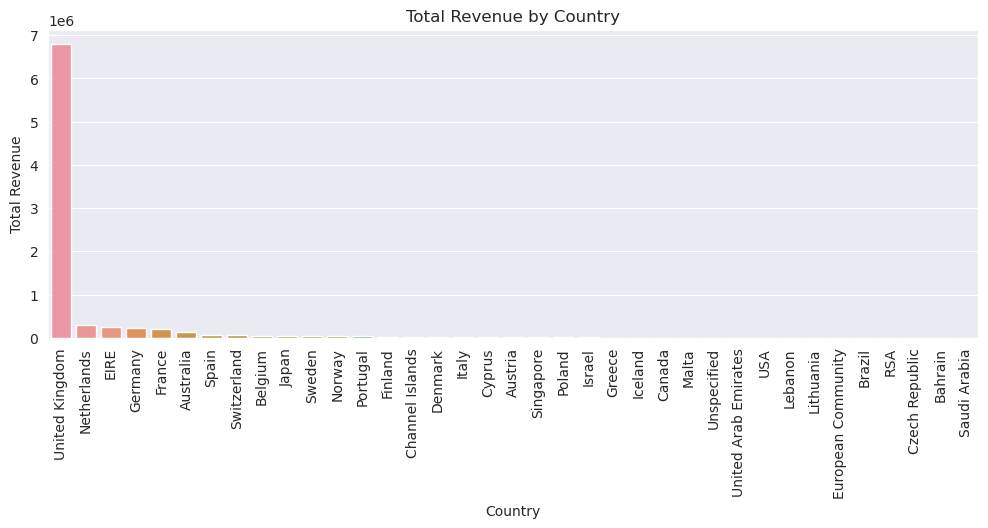

In [17]:
country_revenue = df.groupby("Country")["TotalValue"].sum().sort_values(ascending=False).reset_index()

plt.figure(figsize=(12, 4))
plt.title("Total Revenue by Country")
sns.barplot(data=country_revenue, x="Country", y="TotalValue")
plt.ylabel("Total Revenue")
plt.xticks(rotation=90)
plt.show()

From a total revenue perspective, the **United Kingdom** was the origin of most of it, followed by **Netherlands** and **EIRE**. It makes total sense, since this dataset contains transactions from a UK-based online retail.

### <span id="5-2"></span>5.2. Revenue by Month of the Year

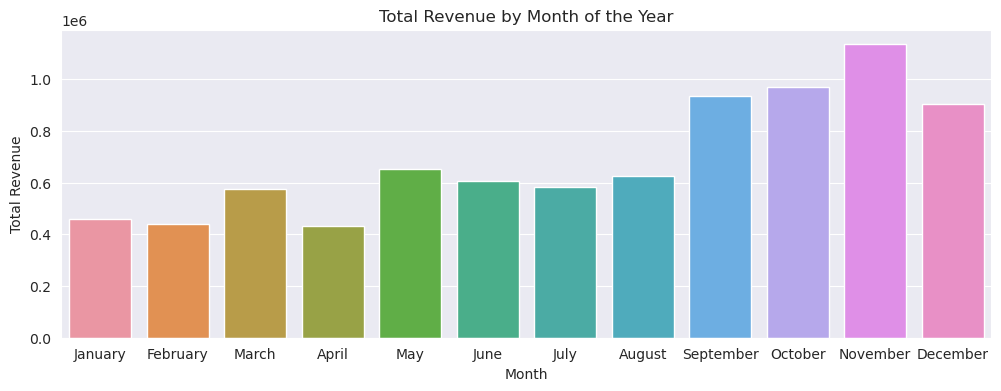

In [18]:
revenue_month = df.groupby(["InvoiceMonth", "InvoiceMonthName"])["TotalValue"].sum().reset_index()
plt.figure(figsize=(12, 4))
plt.title("Total Revenue by Month of the Year")
sns.barplot(data=revenue_month, x="InvoiceMonthName", y="TotalValue")
plt.xlabel("Month")
plt.ylabel("Total Revenue")
plt.show()

The month with the greatest total revenue was November. This can be due to the event known as **Black Friday**, when many retailers offers significant discounts and promotions to their customers.

### <span id="5-3"></span>5.3. Revenue by Day of the Week

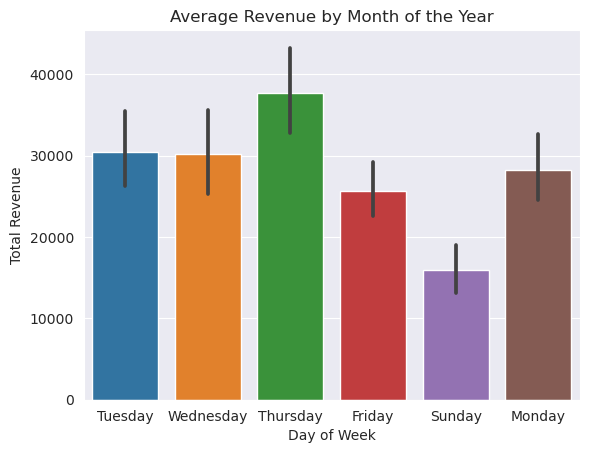

In [19]:
revenue_day = df.groupby(["InvoiceWeekOfYear", "InvoiceDayOfWeek", "InvoiceDayName"])["TotalValue"].sum().reset_index()
revenue_day.groupby(["InvoiceDayOfWeek", "InvoiceDayName"])["TotalValue"].mean().reset_index()
plt.title("Average Revenue by Month of the Year")
sns.barplot(data=revenue_day, x="InvoiceDayName", y="TotalValue")
plt.xlabel("Day of Week")
plt.ylabel("Total Revenue")
plt.show()

The day of the week with the greatest average revenue is _Thursday_, followed by _Tuesday_.

### <span id="5-4"></span>5.4. Top 10 Customers by Revenue

In [20]:
top_10_customers = df_customers["MonetaryValue"].sort_values(ascending=False).head(10)
top_10_customers

CustomerID
12685.0    2863.08
18145.0    2861.55
16928.0    2845.10
15606.0    2840.96
14852.0    2836.69
12473.0    2832.33
14112.0    2816.35
13735.0    2815.29
12356.0    2811.43
18230.0    2810.20
Name: MonetaryValue, dtype: float64

### <span id="5-5"></span>5.5. Customers RFM

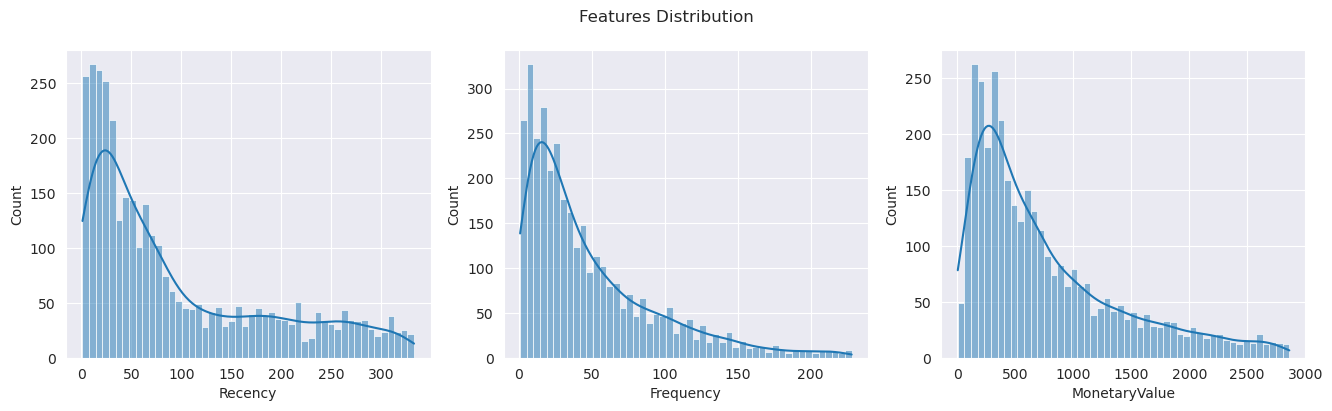

In [21]:
fig, ax = plt.subplots(1, 3, figsize=(16, 4))
fig.suptitle("Features Distribution")
sns.histplot(df_customers["Recency"], bins=50, ax=ax[0], kde=True)
sns.histplot(df_customers["Frequency"], bins=50, ax=ax[1], kde=True)
sns.histplot(df_customers["MonetaryValue"], bins=50, ax=ax[2], kde=True)
fig.show()

The distribution of the RFM features are highly skewed (positive) and far from normality. Normality is an assumption of many machine learning models, including the KMeans model that we will use in our customers segmentation. So in the next step we will perform some preprocessing in our RFM data in order to fit our models.

## <span id="6"></span>6. Customer Segmentation (Clustering)

### <span id="6-1"></span>6.1. Preprocessing

In [22]:
# X is our data

X = df_customers
X.shape

(3505, 3)

From the data exploration steps above, we saw that our RFM features are highly skewed and far from normality, so in the preprocessing phase we need to define some transformations that will approximate our features to the Gaussian distribution. Some common transformations are the Box-Cox, log, squared root and cubic root transformations. We will define each one of them and choose the best one for each feature.

In [23]:
# defining some feature transformers

boxcox_t = PowerTransformer(method="box-cox")
log_t = FunctionTransformer(func=np.log, inverse_func=np.exp)
sqrt_t = FunctionTransformer(func=np.sqrt, inverse_func=lambda x : x ** 2)
cbrt_t = FunctionTransformer(func=np.cbrt, inverse_func=lambda x : x ** 3)

X_boxcox = boxcox_t.fit_transform(X)
X_log = log_t.fit_transform(X).values
X_sqrt = sqrt_t.fit_transform(X).values
X_cbrt = cbrt_t.fit_transform(X).values

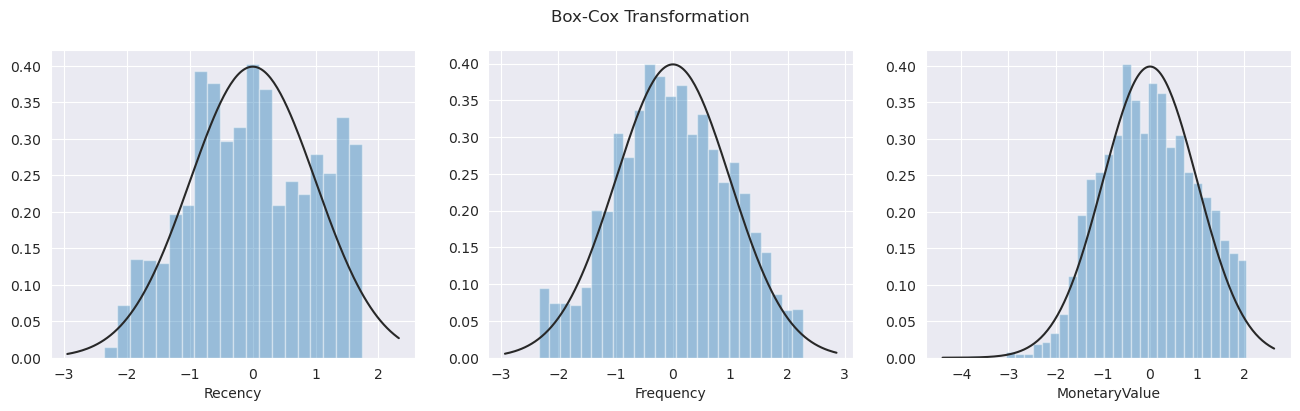

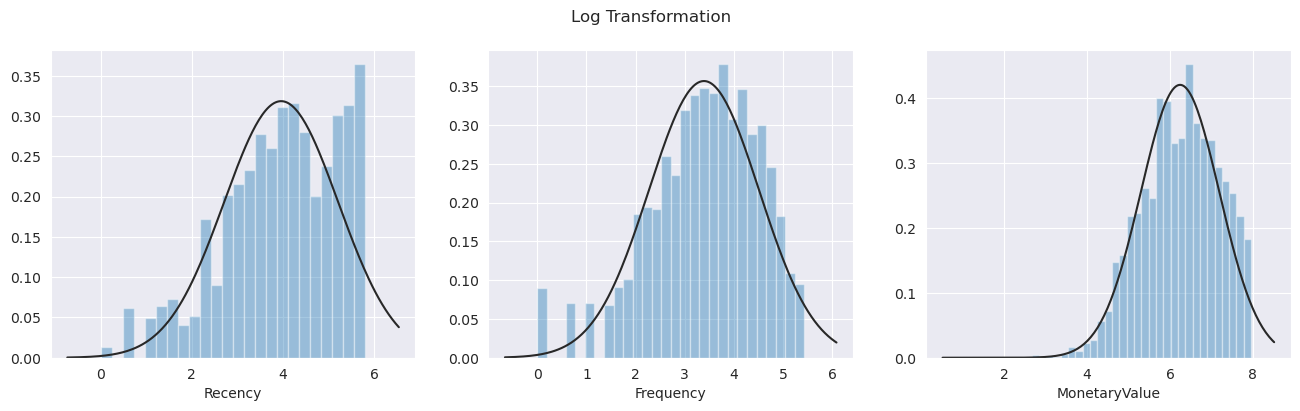

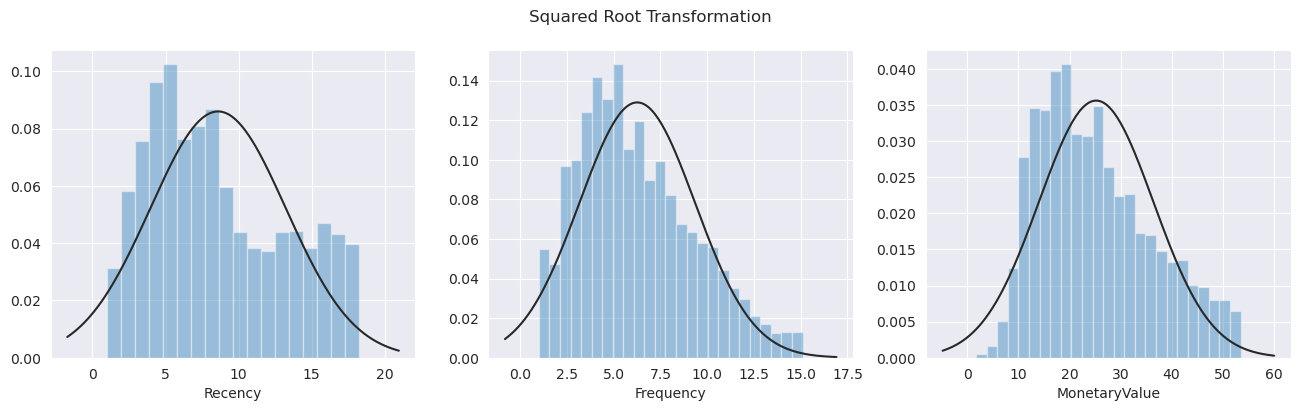

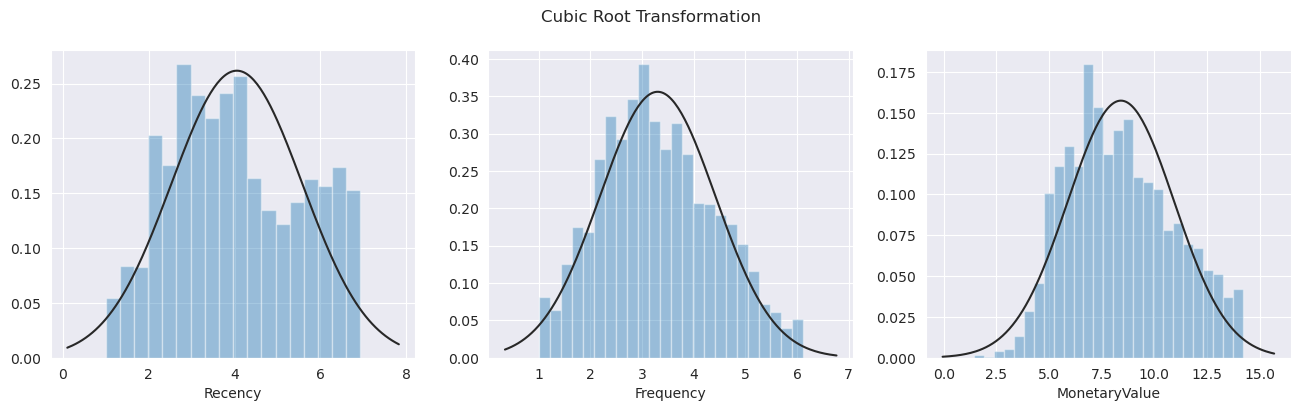

In [24]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
fig.suptitle("Box-Cox Transformation")
for i in range(3):
    ax = axes[i]
    sns.distplot(X_boxcox[:,i], fit=norm, kde=False, ax=ax)
    ax.set_xlabel(df_customers.columns[i])
    
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
fig.suptitle("Log Transformation")
for i in range(3):
    ax = axes[i]
    sns.distplot(X_log[:,i], fit=norm, kde=False, ax=ax)
    ax.set_xlabel(df_customers.columns[i])
    
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
fig.suptitle("Squared Root Transformation")
for i in range(3):
    ax = axes[i]
    sns.distplot(X_sqrt[:,i], fit=norm, kde=False, ax=ax)
    ax.set_xlabel(df_customers.columns[i])
    
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
fig.suptitle("Cubic Root Transformation")
for i in range(3):
    ax = axes[i]
    sns.distplot(X_cbrt[:,i], fit=norm, kde=False, ax=ax)
    ax.set_xlabel(df_customers.columns[i])

It looks like the Box-Cox transformer was the best option for the _Frequency_ variable, and the cubic root for _Recency_ and _MonetaryValue_, so let's proceed to our clustering pipeline definition. In addition to these transformations, clustering methods usually requires the features to range between the same scale, so we will standardize our features with the StandarScaler transformer from scikit-learn.

In [25]:
standard_scaler = StandardScaler()

transformers = ColumnTransformer(
    [
        ("boxcox", boxcox_t, ["Frequency"]),
        ("cbrt", cbrt_t, ["Recency", "MonetaryValue"])
    ],
    remainder="passthrough"
)

preprocessing = Pipeline([
    ("transformers", transformers),
    ("scaler", standard_scaler),
])

Now that we defined our preprocessing steps, let's complete our pipeline with our clustering model. In order to segment customers, we will use the **KMeans** method.

In [26]:
kmeans = KMeans(random_state=seed)

clusterer = Pipeline([
    ("preprocessing", preprocessing),
    ("kmeans", kmeans)
])

The **KMeans** model has a single hyperparameter called _n_clusters_ indicating the total number of clusters for our data. We will find the ideal number of clusters using the "elbow" technique and the silhouette analysis.

### <span id="6-2"></span>6.2. Finding Number of Clusters

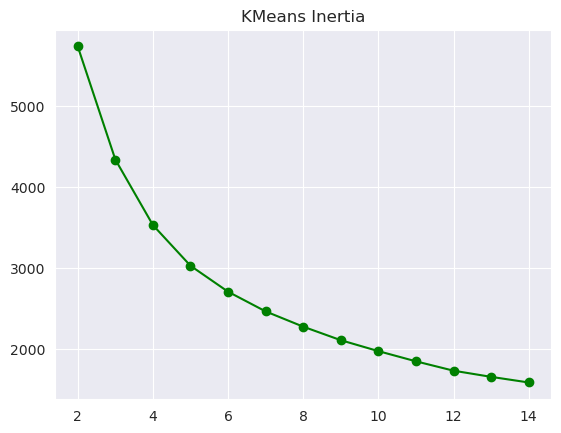

In [27]:
n_clusters = np.arange(2, 15)
inertia = []
for k in n_clusters:
    kmeans = clusterer.steps[-1][1]
    kmeans.set_params(n_clusters=k)
    clusterer.fit(X)
    inertia.append(kmeans.inertia_)
    
plt.title("KMeans Inertia")
plt.plot(n_clusters, inertia, color="green", marker="o")
plt.show()

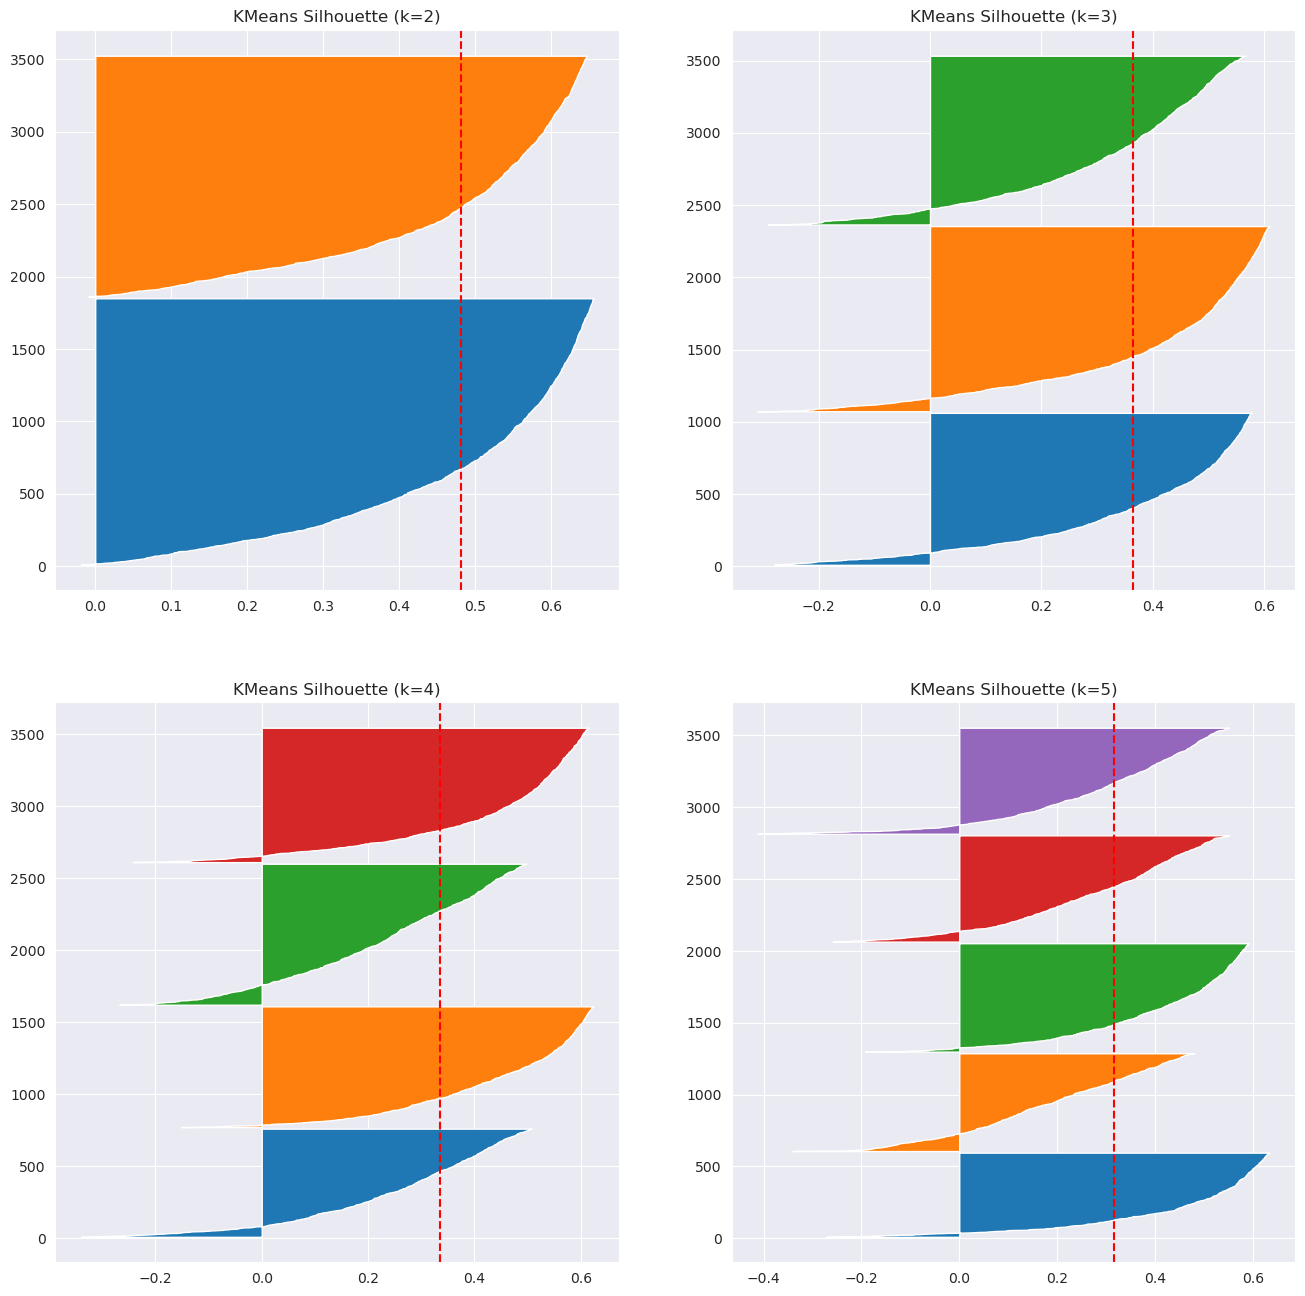

In [28]:
n_clusters = np.arange(2, 6)

def plot_silhouettes(X, labels, ax):
    unique_labels = np.unique(labels)
    n_clusters = len(unique_labels)
    ax.set_title(f"KMeans Silhouette (k={n_clusters})")
    
    avg_silhouette = silhouette_score(X, labels, random_state=seed)
    clusters_silhouettes = silhouette_samples(X, labels)
    
    y_lower = 10
    for i in (unique_labels):
        cluster_silhouettes = np.sort(clusters_silhouettes[labels == i])
        cluster_size = len(cluster_silhouettes)
        
        y_upper = y_lower + cluster_size
        ax.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            cluster_silhouettes,
        )
        
        y_lower = y_upper + 10
        
    ax.axvline(avg_silhouette, color="red", linestyle="--")

n_cols = 2
n_rows = math.ceil(len(n_clusters) / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 8))
for i, k in enumerate(n_clusters):
    ax = axes[i // n_cols][i % n_cols]
    kmeans = clusterer.steps[-1][1]
    kmeans.set_params(n_clusters=k)
    labels = clusterer.fit_predict(X)
    X_transf = clusterer.transform(X)
    plot_silhouettes(X_transf, labels, ax)

# removing unused axes    
i += 1
while i < (n_rows * n_cols):
    ax = axes[i // n_cols][i % n_cols]
    ax.remove()

It seems that the best fit for the number of clusters is $k = 2$. So now we will build our final clustering model and evaluate some statistics about each cluster. We also will try to visualize the clusters with a 3D scatterplot.

### <span id="6-3"></span>6.3. Final Model

In [29]:
kmeans = clusterer.steps[-1][1]
kmeans.set_params(n_clusters=2)
labels = clusterer.fit_predict(X)
df_customers["Label"] = labels
df_customers.head()

,Recency,Frequency,MonetaryValue,Label
CustomerID,,,,
12348.0,76,31,1797.24,1
12349.0,19,73,1757.55,1
12350.0,311,17,334.40,0
12352.0,37,67,1405.28,1
12353.0,205,4,89.00,0


In [30]:
def Q1(x):
    return np.percentile(x, 25)

def Q3(x):
    return np.percentile(x, 75)

df_customers.groupby("Label")[["Recency", "Frequency", "MonetaryValue"]].agg({
    "Recency": [np.mean, Q1, Q3],
    "Frequency": [np.mean, Q1, Q3],
    "MonetaryValue": [np.mean, Q1, Q3]
})

Recency               Frequency              MonetaryValue  \
             mean    Q1     Q3       mean    Q1     Q3          mean   
Label                                                                  
0      139.868007  53.0  226.0  19.700163   9.0   27.0    339.514694   
1       46.280649  13.0   61.0  80.874399  45.0  107.0   1227.652092   

                            
             Q1         Q3  
Label                       
0      168.2400   436.1800  
1      710.0625  1646.2775

In [31]:
X_transf = preprocessing.fit_transform(X)

fig = px.scatter_3d(df_customers, x="Recency", y="Frequency", z="MonetaryValue", color=df_customers["Label"])
fig.show()

It seems our clustering model is able to do a good job clustering the customers. In this kernel we found that 2 is a good value for the number of clusters, but this value can vary depending on the business needs. With the model resulted from our analysis, it is possible to the company to address custom marketing strategies and promotions directed to customers considering the group they are labeled.